# Double asperity simulations

In the previous tutorial, we looked at a rather simple configuration, that of a single asperity which exhibited repetitive, stable limit cycles. In this tutorial, we'll consider a fault with two asperities, one of size $f L_a$, and another of size $(1-f)L_a$. We begin with $f = 0.5$, meaning that both asperities are of equal size $0.5 L_a$. Later on, we can tune this parameter $f$ to see how the behaviour changes.

In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
base_dir = os.path.join("/", "home")
qdyn_dir = os.path.join(base_dir, "qdyn", "src")
plot_dir = os.path.join(base_dir, "qdyn", "utils", "post_processing")
sys.path.append(qdyn_dir)
sys.path.append(plot_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

We prepare the simulation in a similar way as we have done in the single asperity case:

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
f = 0.5                     # Size ratio of asperities
L = 15                      # Length of fault / nucleation length
ab_ratio = 0.8              # a/b of asperity
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 1         # Finite fault
set_dict["TMAX"] = 25*t_yr     # Maximum simulation time [s]
set_dict["NTOUT"] = 100        # Save output every N steps
set_dict["NXOUT"] = 2          # Snapshot resolution (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity [m/s]
set_dict["MU"] = 3e10          # Shear modulus [Pa]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 1.2e-2    # Direct effect
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]

# Compute relevant length scales:
# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = Lb / cab_ratio
# Fault length [m]
L *= Lc
L1 = 0.5 * f * L
L2 = 0.5 * (1 - f) * L
p1 = L / 3 - L / 2
p2 = 2 * L / 3 - L / 2

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)
asp1 = (x > (p1 - L1 / 2)) & (x < (p1 + L1 / 2))
asp2 = (x > (p2 - L2 / 2)) & (x < (p2 + L2 / 2))

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Location on the fault (middle) for time series output
set_dict["IC"] = N // 2

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
p.mesh_dict["A"][asp1 + asp2] = ab_ratio * p.mesh_dict["B"][asp1 + asp2]

# Write input to qdyn.in
p.write_input()

True

We can visualise the two asperities by plotting $(a-b)$ versus position on the fault:

<IPython.core.display.Javascript object>


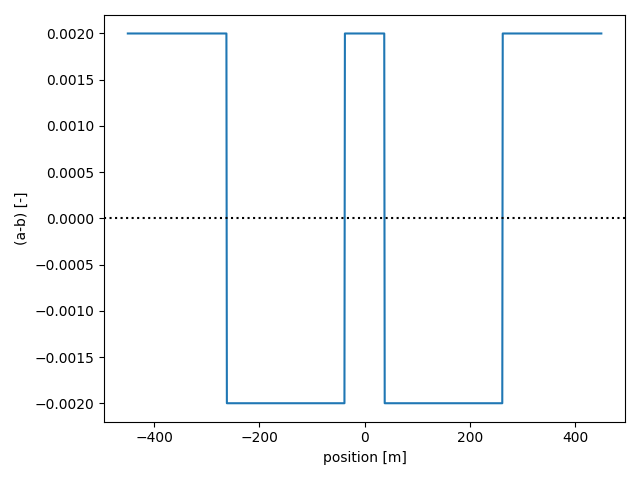

In [3]:
plt.clf()
plt.plot(x, p.mesh_dict["A"] - p.mesh_dict["B"])
plt.axhline(0, ls=":", c="k")
plt.xlabel("position [m]")
plt.ylabel("(a-b) [-]")
plt.tight_layout()
plt.show()

We then run this simulation with `p.run()`

In [4]:
p.run()

0

Then read the output:

In [5]:
p.read_output()

True

To get a general impression of how our fault behaved, we plot the time series of the shear stress $\tau$ and state $\theta$ at the centre of the fault, and maximum slip rate $v_{max}$ recorded over the entire fault.

<IPython.core.display.Javascript object>


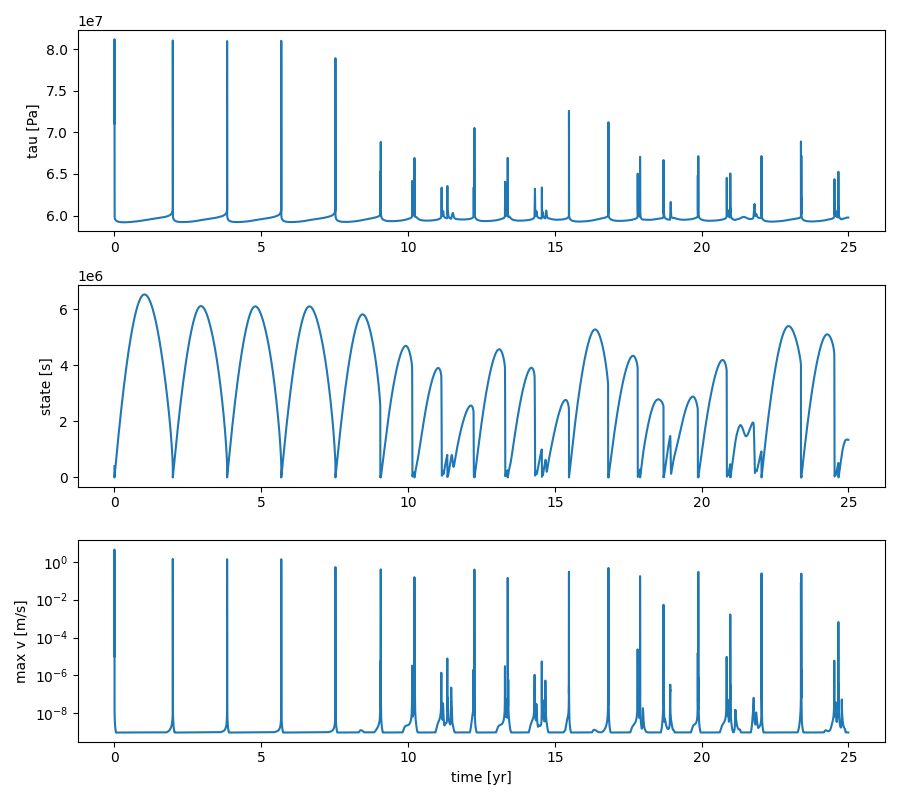

In [6]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

In this double-asperity scenario, we see the opposite of what we saw in the single-asperity case: instead of converging to a stable limit cycle, the earthquake cycles diverge into (deterministic) chaos. This is clearly illustrated by the slip rate evolution:

<IPython.core.display.Javascript object>


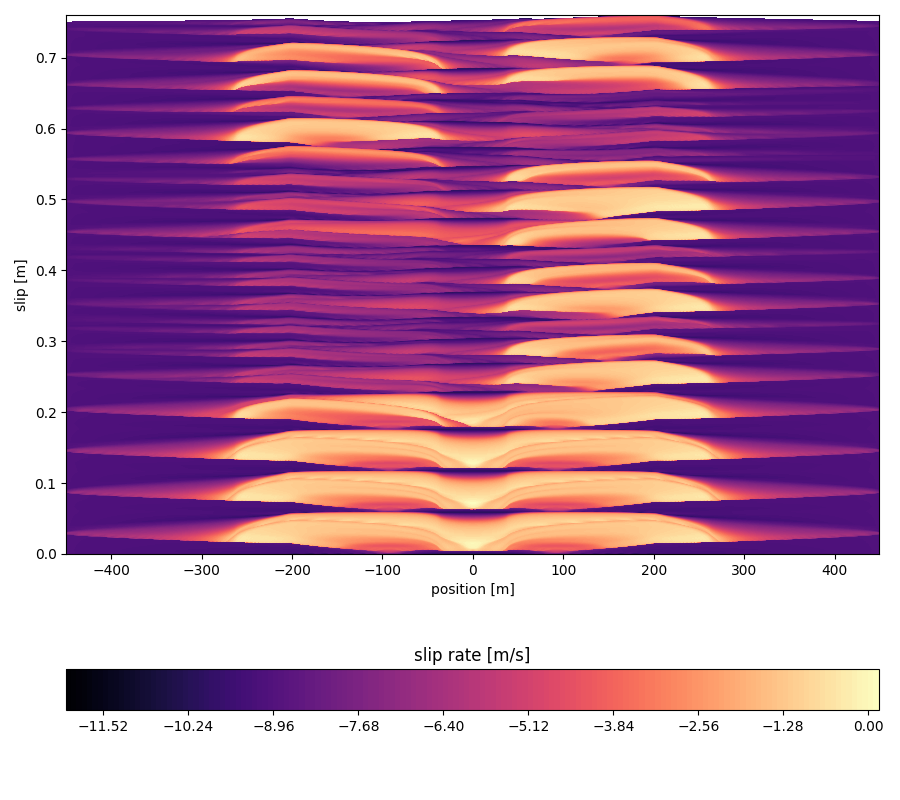

In [7]:
# Spatio-temporal evolution of slip rates
qdyn_plot.slip_profile(p.ox, warm_up=1*t_yr)

At first, both asperities rupture simultaneously, but after a few cycles, only the right asperity ruptures seismically while the left one mostly creeps. This pattern is reversed after a few more cycles. Another way of seeing this is with an animation:

In [8]:
# This will take a minute or two...
qdyn_plot.animation_slip(p.ox, warm_up=1*t_yr)

## Exercise

Vary `f` to see how the fault's response changes. Why does `f = 0.5` show chaotic behaviour, but not `f = 0.2`? Note that `f = 0.4` is the same as `f = 0.6` (it simply changes the order of the asperities).